In [70]:
import pandas as pd
import numpy as np
import re

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

seed = 20191194

# Cleaning

In [195]:
df = pd.read_csv('case_study_data_ver1.csv', sep = ';')

In [196]:
df = df.dropna() # getting rid of all NULLs

In [197]:
df['QTY'] = df['QTY'].astype(str)
outtakes = df[df.QTY.str.contains('[a-zA-Z]|\.\d\d$|\.\d\d\d\d$')]
df = df.drop(outtakes.index)
df['QTY'] = df['QTY'].apply(lambda x: re.sub('\.','',re.sub('\..$','',x))).astype(float)
df = df.drop([key for key in list(df.keys()) if df[key].sum()==0], axis=1)

# Feature Engineering Store:Item Combination

In [198]:
df = df[(df.STORE_ID==3)&(df.ITEM_ID==4)]

In [199]:
df = df.sort_values('DATE_ID',kind='mergesort')
df.head()

,ITEM_ID,DATE_ID,STORE_ID,CAT_DAYOFWEEK,DUM_FREEWEEKDAY,DUM_WORKSATURDAY,DUM_SPRINGBREAK,DUM_SUMMERBREAK,DUM_FALLBREAK,DUM_WINTERBREAK,...,NUM_HOLIDAY_WHIT_TO,NUM_HOLIDAY_XMAS_FROM,NUM_HOLIDAY_XMAS_TO,NUM_SCHOOLBREAK_FROM_END,NUM_SCHOOLBREAK_TO_START,NUM_SCHOOLBREAK_FROM_START,NUM_SCHOOLBREAK_TO_END,QTY,PRICE,CUSTOMER
97,4.0,1.0,3.0,5,0,0,0,0,0,1,...,134.0,8.0,358.0,0.0,0.0,15.0,1.0,20.0,1101.45,1607.0
681,4.0,3.0,3.0,0,0,0,0,0,0,0,...,132.0,10.0,356.0,2.0,80.0,0.0,0.0,7.0,1101.45,1498.0
1192,4.0,4.0,3.0,1,0,0,0,0,0,0,...,131.0,11.0,355.0,3.0,79.0,0.0,0.0,4.0,1101.45,1378.0
1790,4.0,5.0,3.0,2,0,0,0,0,0,0,...,130.0,12.0,354.0,4.0,78.0,0.0,0.0,8.0,1101.45,1304.0
2431,4.0,6.0,3.0,3,0,0,0,0,0,0,...,129.0,13.0,353.0,5.0,77.0,0.0,0.0,7.0,1101.45,1538.0


In [200]:
# add additional features last x days (This step costs data, critical when there isnt much)
# here we could distinguish: if x <= 5% of data points, use additional features, else not
last_x_days = 7
prev_rows = {}
for num in range(1,last_x_days+1):
    prev_rows['qty_prev_{}d'.format(num)] = [df.QTY.values[i-num] for i in range(len(df))]
    prev_rows['qty_delta_{}d'.format(num)] = [df.QTY.values[i] - df.QTY.values[i-num] for i in range(len(df))]
    prev_rows['price_prev_{}d'.format(num)] = [df.PRICE.values[i-num] for i in range(len(df))]
    prev_rows['price_delta_{}d'.format(num)] = [df.PRICE.values[i] - df.PRICE.values[i-num] for i in range(len(df))]
    prev_rows['customer_prev_{}d'.format(num)] = [df.CUSTOMER.values[i-num] for i in range(len(df))]
    prev_rows['customer_delta_{}d'.format(num)] = [df.CUSTOMER.values[i] - df.CUSTOMER.values[i-num] for i in range(len(df))]
    
additional_features = pd.DataFrame(prev_rows)
additional_features.head()

,qty_prev_1d,qty_delta_1d,price_prev_1d,price_delta_1d,customer_prev_1d,customer_delta_1d,qty_prev_2d,qty_delta_2d,price_prev_2d,price_delta_2d,...,price_prev_6d,price_delta_6d,customer_prev_6d,customer_delta_6d,qty_prev_7d,qty_delta_7d,price_prev_7d,price_delta_7d,customer_prev_7d,customer_delta_7d
0,48.0,-28.0,922.95,178.5,2785.0,-1178.0,21.0,-1.0,922.95,178.5,...,922.95,178.5,2008.0,-401.0,14.0,6.0,922.95,178.5,1319.0,288.0
1,20.0,-13.0,1101.45,0.0,1607.0,-109.0,48.0,-41.0,922.95,178.5,...,922.95,178.5,1947.0,-449.0,6.0,1.0,922.95,178.5,2008.0,-510.0
2,7.0,-3.0,1101.45,0.0,1498.0,-120.0,20.0,-16.0,1101.45,0.0,...,922.95,178.5,1964.0,-586.0,7.0,-3.0,922.95,178.5,1947.0,-569.0
3,4.0,4.0,1101.45,0.0,1378.0,-74.0,7.0,1.0,1101.45,0.0,...,922.95,178.5,2349.0,-1045.0,12.0,-4.0,922.95,178.5,1964.0,-660.0
4,8.0,-1.0,1101.45,0.0,1304.0,234.0,4.0,3.0,1101.45,0.0,...,922.95,178.5,2380.0,-842.0,7.0,0.0,922.95,178.5,2349.0,-811.0


In [201]:
#merge it
for key in list(additional_features.keys()):
    df['{}'.format(key)]=additional_features['{}'.format(key)].values

df.head()

,ITEM_ID,DATE_ID,STORE_ID,CAT_DAYOFWEEK,DUM_FREEWEEKDAY,DUM_WORKSATURDAY,DUM_SPRINGBREAK,DUM_SUMMERBREAK,DUM_FALLBREAK,DUM_WINTERBREAK,...,price_prev_6d,price_delta_6d,customer_prev_6d,customer_delta_6d,qty_prev_7d,qty_delta_7d,price_prev_7d,price_delta_7d,customer_prev_7d,customer_delta_7d
97,4.0,1.0,3.0,5,0,0,0,0,0,1,...,922.95,178.5,2008.0,-401.0,14.0,6.0,922.95,178.5,1319.0,288.0
681,4.0,3.0,3.0,0,0,0,0,0,0,0,...,922.95,178.5,1947.0,-449.0,6.0,1.0,922.95,178.5,2008.0,-510.0
1192,4.0,4.0,3.0,1,0,0,0,0,0,0,...,922.95,178.5,1964.0,-586.0,7.0,-3.0,922.95,178.5,1947.0,-569.0
1790,4.0,5.0,3.0,2,0,0,0,0,0,0,...,922.95,178.5,2349.0,-1045.0,12.0,-4.0,922.95,178.5,1964.0,-660.0
2431,4.0,6.0,3.0,3,0,0,0,0,0,0,...,922.95,178.5,2380.0,-842.0,7.0,0.0,922.95,178.5,2349.0,-811.0


In [202]:
# Exlude first x days since additional features are actually showing the last days^^
df=df.drop(df[:last_x_days].index)

In [203]:
# Exclude: 
# - ID's, 
# - what we can't know at prediction time 
features = [col for col in list(df.keys()) if (col not in list(df.keys())[:3]) & \
                                              (col not in ['QTY', 'CUSTOMER'])]

# Split Data Sets

In [204]:
# Split training & new data (7 days)
df_validation = df[df.DATE_ID >= df.DATE_ID.max()-7]
df_training = df.drop(df_validation.index)

In [205]:
X,y = shuffle(df_training, np.log(df_training.QTY), random_state = seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

# Training

In [206]:
#Training base models
models = {'GradientBoostingRegressor': GradientBoostingRegressor(random_state=seed),
          'RandomForestRegressor': RandomForestRegressor(random_state=seed)}

models_trained = {}
for model in models:
    models_trained[model+'_base'] = models[model].fit(X_train[features],y_train)

# Tuning

# Evaluation

In [175]:
def mae(model_name, trained_model, xtest, ytest, prnt = False):
    """ Returns Model Name and Mean Absolute Error."""
    yhat = trained_model.predict(xtest)
    mae = np.exp(np.mean(np.abs(yhat - ytest))) #undo log transformation for comparison
    if prnt == True:
        print('{} Performance'.format(model_name))
        print('Mean Absolute Error: {:0.4f}\n'.format(mae))
    return model_name, mae

In [207]:
#Saving performance measures for comparison
performance = {}
for model in models_trained:
    evaluation = mae(model, models_trained[model] , X_test[features], y_test,prnt=True)
    performance[evaluation[0]] = [evaluation[1]]


GradientBoostingRegressor_base Performance
Mean Absolute Error: 1.0887

RandomForestRegressor_base Performance
Mean Absolute Error: 1.1100



# Selection

In [ ]:
# Compare trained models, use best






#### Notes

In [ ]:
# ERGÄNZE:


# DONE
# Sortieren nach Datum, nach Festlegung Store/Item Kombo
# die Anzahl der Kunden der vorherigen Tage nehmen, 
# ebenso wie die Preise der vergangenen Tage,
# als auch deren Änderungen verwenden!
# Gleiches gilt für Mengenänderungen Abverkauf
# und Kundenanzahlveränderungen.

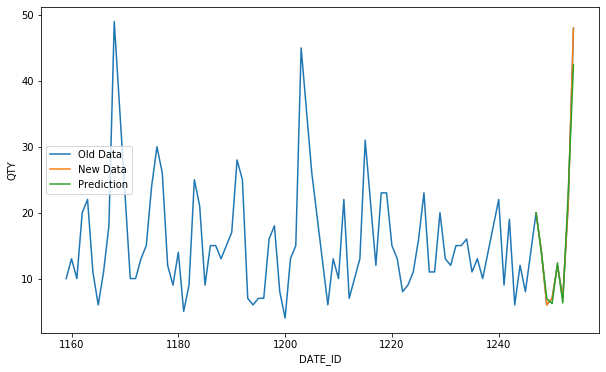

In [208]:
# Does it work?
lookback_days = 90
plt.figure(figsize=(10,6))
sns.lineplot(df.DATE_ID[-lookback_days:],df.QTY[-lookback_days:], label = "Old Data")
# sns.lineplot(df[df.DATE_ID > 1000].DATE_ID[-lookback_days:],np.log(df.QTY[-lookback_days:]), label = "Old Data")
sns.lineplot(df_validation.DATE_ID,df_validation.QTY, label = "New Data")
# sns.lineplot(df_validation.DATE_ID,np.log(df_validation.QTY), label = "New Data")
sns.lineplot(df_validation.DATE_ID,np.exp(models_trained['GradientBoostingRegressor_base'].predict(df_validation[features])), label = "Prediction")
plt.show()

In [102]:
#Tuning loop with
params_list = []
params_grid_gbr = {
    'loss': ['ls','lad', 'huber', 'quantile'],
    'learning_rate ':list(np.linspace(0.001,0.01,10))
}

SyntaxError: invalid syntax (<ipython-input-102-3201c8185414>, line 6)

In [111]:
list(np.arange(0.001, 0.01, 0.001))

[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001]

In [157]:
list(np.linspace(0.001,0.01,10))

[0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01]

In [158]:
np.log(5)

1.6094379124341003

In [159]:
np.exp(np.log(5))

4.999999999999999